In [1]:
pip install pygame

Note: you may need to restart the kernel to use updated packages.


In [2]:
# =============================
# Import Library yang Diperlukan
# =============================

In [3]:
import csv
import heapq
import time
import numpy as np
import pygame
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

pygame 2.6.1 (SDL 2.28.4, Python 3.12.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [4]:
# =============================
# Fungsi Membaca CSV Labirin
# =============================

In [5]:
def get_maze(file):
    """
    Membaca file CSV labirin.
    Nilai dalam CSV:
      0 -> ruang kosong
      1 -> dinding
      2 -> titik start
      3 -> titik goal
    """
    start = None
    goal = None
    maze = []
    with open(file, 'r', encoding='utf-8-sig') as f:
        reader = csv.reader(f)
        for i, row in enumerate(reader):
            numeric_row = []
            for j, value in enumerate(row):
                try:
                    num = int(value)
                except ValueError:
                    continue  # Lewati nilai yang tidak bisa dikonversi
                numeric_row.append(num)
                if num == 2:
                    start = (i, j)
                elif num == 3:
                    goal = (i, j)
            maze.append(numeric_row)
    # Jika tiap baris memiliki panjang berbeda, tambahkan dinding (1) untuk padding
    max_len = max(len(r) for r in maze)
    for row in maze:
        if len(row) < max_len:
            row.extend([1] * (max_len - len(row)))
    return maze, start, goal

In [6]:
# =============================
# Menampilkan Labirin Secara Statik
# =============================

In [7]:
def display_maze_static(maze, title='Labirin Asli'):
    maze_arr = np.array(maze)
    # Colormap:
    # 0: putih (ruang kosong), 1: hitam (dinding), 2: hijau (start), 3: merah (goal)
    cmap = ListedColormap(['white','black','green','red'])
    plt.figure(figsize=(6,6))
    plt.imshow(maze_arr, cmap=cmap, origin='upper')
    plt.title(title)
    plt.xticks([]), plt.yticks([])
    plt.show()

In [8]:
# =============================
# Implementasi A* dengan Konsep Wavefront
# =============================

In [9]:
def wavefront_algorithm(maze, goal):
    """
    Menyebarkan nilai wavefront mulai dari goal ke seluruh sel yang dapat diakses.
    Sel yang bukan dinding diinisialisasi dengan -1, dan dinding dengan None.
    """
    rows, cols = len(maze), len(maze[0])
    wavefront = [[-1 if maze[i][j] != 1 else None for j in range(cols)] for i in range(rows)]
    queue = [goal]
    wavefront[goal[0]][goal[1]] = 0  # Goal diberi nilai 0
    
    while queue:
        x, y = queue.pop(0)
        for dx, dy in [(0,1), (1,0), (0,-1), (-1,0)]:
            nx, ny = x + dx, y + dy
            if 0 <= nx < rows and 0 <= ny < cols:
                if wavefront[nx][ny] == -1 and maze[nx][ny] != 1:
                    wavefront[nx][ny] = wavefront[x][y] + 1
                    queue.append((nx, ny))
    return wavefront

def reconstruct_path(wavefront, start, goal):
    """
    Merektruksi jalur dari start ke goal dengan memilih tetangga yang memiliki nilai wavefront terkecil.
    """
    path = []
    current = start
    while current != goal:
        path.append(current)
        x, y = current
        # Mendapatkan semua tetangga yang valid
        neighbors = [(x+dx, y+dy) for dx, dy in [(0,1), (1,0), (0,-1), (-1,0)]]
        neighbors = [n for n in neighbors if 0 <= n[0] < len(wavefront) and 0 <= n[1] < len(wavefront[0])
                     and wavefront[n[0]][n[1]] is not None]
        # Pilih tetangga dengan nilai terkecil (menuju goal)
        current = min(neighbors, key=lambda n: wavefront[n[0]][n[1]])
    path.append(goal)
    return path

In [10]:
# =============================
# Menampilkan Labirin dengan Jalur A* Secara Statik
# =============================

In [11]:
def display_maze_with_path(maze, path, title='Labirin dengan Jalur A*'):
    maze_arr = np.array(maze)
    maze_path = maze_arr.copy()
    # Tandai jalur dengan nilai 4 (hanya untuk sel kosong)
    for (i, j) in path:
        if maze_path[i][j] == 0:
            maze_path[i][j] = 4
    # Colormap baru: 4 -> biru untuk jalur
    cmap = ListedColormap(['white','black','green','red','blue'])
    plt.figure(figsize=(6,6))
    plt.imshow(maze_path, cmap=cmap, origin='upper')
    plt.title(title)
    plt.xticks([]), plt.yticks([])
    plt.show()

In [12]:
# =============================
# Visualisasi dan Animasi Menggunakan pygame
# =============================

In [13]:
def draw_maze(screen, maze, cell_size, path, robot_pos=None):
    """
    Menggambar labirin ke layar pygame.
    - Ruang kosong: putih
    - Dinding: hitam
    - Start: hijau
    - Goal: merah
    - Jalur: biru
    - Robot: kuning
    """
    colors = {
        0: (255, 255, 255),  # putih
        1: (0, 0, 0),        # hitam
        2: (0, 255, 0),      # hijau
        3: (255, 0, 0),      # merah
        4: (0, 0, 255)       # biru (untuk jalur)
    }
    
    rows, cols = len(maze), len(maze[0])
    for i in range(rows):
        for j in range(cols):
            rect = pygame.Rect(j * cell_size, i * cell_size, cell_size, cell_size)
            color = colors.get(maze[i][j], (255, 255, 255))
            pygame.draw.rect(screen, color, rect)
            pygame.draw.rect(screen, (200, 200, 200), rect, 1)  # garis batas
            
    # Tandai jalur (jika ada)
    for (i, j) in path:
        if maze[i][j] == 0:
            rect = pygame.Rect(j * cell_size, i * cell_size, cell_size, cell_size)
            pygame.draw.rect(screen, colors[4], rect)
    
    # Tandai posisi robot (jika ada)
    if robot_pos:
        i, j = robot_pos
        rect = pygame.Rect(j * cell_size, i * cell_size, cell_size, cell_size)
        pygame.draw.rect(screen, (255, 255, 0), rect)  # kuning untuk robot

def run_simulation(maze, path, cell_size=30, delay=300):
    """
    Menjalankan simulasi pergerakan robot dari start ke goal menggunakan pygame.
    delay: waktu tunda (ms) antara pergerakan.
    """
    pygame.init()
    rows, cols = len(maze), len(maze[0])
    screen = pygame.display.set_mode((cols * cell_size, rows * cell_size))
    pygame.display.set_caption("Simulasi A* dengan Wavefront (pygame)")
    clock = pygame.time.Clock()
    running = True
    step = 0  # indeks langkah pada jalur
    
    while running:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False
                
        screen.fill((255, 255, 255))
        
        # Posisi robot saat ini (berdasarkan langkah yang telah ditempuh)
        current_robot_pos = path[step] if step < len(path) else path[-1]
        draw_maze(screen, maze, cell_size, path, robot_pos=current_robot_pos)
        pygame.display.flip()
        
        pygame.time.wait(delay)
        step += 1
        if step >= len(path):
            pygame.time.wait(1000)
            running = False
        
        clock.tick(60)
    pygame.quit()


In [14]:
# =============================
# Main Program
# =============================

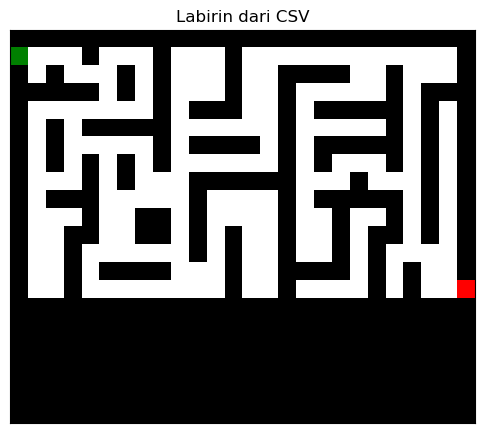

Start: (1, 0), Goal: (14, 25)

Jalur ditemukan:
[(1, 0), (1, 1), (1, 2), (1, 3), (2, 3), (2, 4), (2, 5), (3, 5), (4, 5), (4, 4), (4, 3), (5, 3), (6, 3), (6, 4), (6, 5), (6, 6), (6, 7), (7, 7), (8, 7), (8, 8), (8, 9), (7, 9), (7, 10), (7, 11), (7, 12), (7, 13), (7, 14), (6, 14), (5, 14), (4, 14), (3, 14), (2, 14), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (2, 22), (3, 22), (4, 22), (5, 22), (6, 22), (7, 22), (8, 22), (9, 22), (10, 22), (11, 22), (12, 22), (12, 23), (12, 24), (13, 24), (14, 24), (14, 25)]


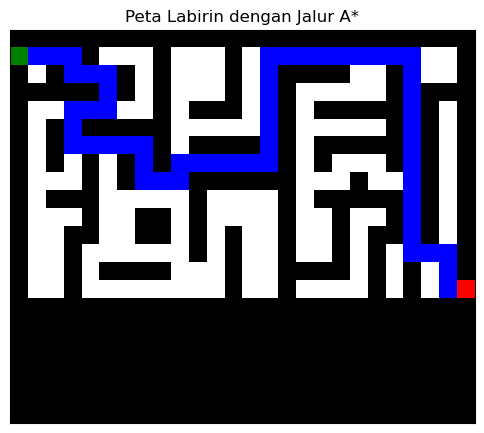

In [15]:
if __name__ == '__main__':
    # Ganti path berikut sesuai lokasi file CSV labirin Anda secara lokal.
    csv_file = 'map 3.csv'  # Contoh: 'map_3.csv'
    
    # Membaca CSV labirin
    maze, start, goal = get_maze(csv_file)
    
    # Tampilkan labirin asli (secara statik menggunakan matplotlib)
    display_maze_static(maze, title='Labirin dari CSV')
    
    print(f"Start: {start}, Goal: {goal}")
    
    # Implementasi A* dengan konsep wavefront
    wavefront = wavefront_algorithm(maze, goal)
    path = reconstruct_path(wavefront, start, goal)
    
    print("\nJalur ditemukan:")
    print(path)
    
    # Tampilkan peta labirin dengan jalur (secara statik)
    display_maze_with_path(maze, path, title='Peta Labirin dengan Jalur A*')
    
    # Jalankan animasi simulasi pergerakan robot menggunakan pygame
    run_simulation(maze, path, cell_size=30, delay=300)